In [17]:
# Future Imports
from __future__ import print_function, division
# iPython Magic Words
# Inlines Matplotlib figures inside IDE instead of separate windows
%matplotlib inline
# Python Libraries
import time
# 3rd Party Libraries
import theano
from theano import tensor as T
from theano import function, pp
import numpy as np
# Initialize Random Seed
np.random.seed(int(time.time()))
import matplotlib.pyplot as plt
from IPython.core.display import display, clear_output

In [19]:
"""
Understanding Deep Learning with Theano
"""
# Defines a tensor matrix with a dynamic scalar, 'x'
X = T.dmatrix('x')
# Symbolic function Y is the tensor matrix X squared (element-wise)
Y = X ** 2
# Calculate the derivative sum of Y with respect to X
# NOTE: input Y to gradient must be a scalar, so Y.sum()
Z = T.grad(Y.sum(), X)
# F is a compiled function with inputs X, the tensor matrix, and Y, the squared tensor matrix
F = function([X], [Y, Z])
# Print out the unoptimized gradient function
print('F: {}'.format(pp(F.maker.fgraph.outputs[0])))
print('dF/dX: {}'.format(pp(F.maker.fgraph.outputs[1])))

F: sqr(x)
dF/dX: (TensorConstant{(1, 1) of 2.0} * x)


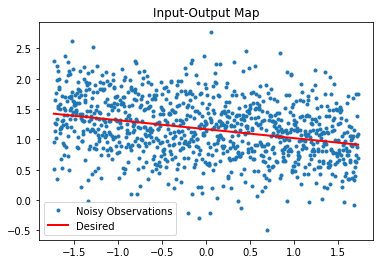

In [22]:
"""
Optimizing a Simple Model in Pure Theano
"""
sigma = np.sqrt(0.5)
N = 1000

# numpy.random.normal(loc=0.0, scale=1.0, size=None))
gaussianNoise = np.random.normal(loc=0, scale=sigma**2, size=N)
x = np.arange(N)
# Standardize the inputs
stdX = (x-x.mean())/x.std()
# Get random initial conditions
w, b = np.random.randn(2)

# Desired output
target = w*stdX + b
# Desired output with gaussian noise
noisyDesired = target + gaussianNoise

# Plot Noisy Observations and Desired
plt.plot(stdX, noisyDesired, '.')
plt.plot(stdX, target, '-r', linewidth=2.)
plt.legend(('Noisy Observations', 'Desired'))
plt.title('Input-Output Map')
display(plt.gca())

W before example weight update: 0.01
W after example weight update: 0.0001


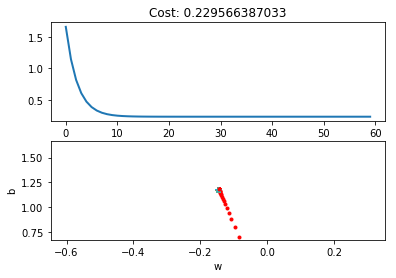

In [31]:
# Theano Model
X, Y = T.dvectors('input', 'target')
W = theano.shared(0.01)
B = theano.shared(0.)
Z = W*X + B
# Mean squared cost function
Cost = ((Y-Z)**2).mean()
params = [W, B]

# Updated Weights Example (of W**2)
updates = ((W, W**2),)
print('W before example weight update: {}'.format(W.get_value()))
doubleW = function([], [], updates=updates)
doubleW()
print('W after example weight update: {}'.format(W.get_value()))

learningRate = 0.1
# Make gradient functions for each W,B input
gradients = [T.grad(Cost, p) for p in params]
updates = [(p, p - learningRate*g) for p, g in zip(params, gradients)]

# Train the network function
# X,Y inputs, Cost output function, with weights updated as W-learningRate*gradient
train = function([X, Y], Cost, updates=updates)

EPOCHS = 60
costList = []
x = stdX
y = noisyDesired
fig = plt.figure()
for i in range(EPOCHS):
    # Train once
    costList.append(train(x, y))
    wHat, bHat = W.get_value(), B.get_value()
    # Display Cost Function
    plt.subplot(211)
    # Clear Current Axis
    plt.cla()
    plt.title('Cost: {}'.format(costList[-1]))
    plt.plot(costList, linewidth=2.)

    # Weight Space
    plt.subplot(212)
    plt.plot(w, b, '*', linewidth=2.)
    plt.plot(wHat, bHat, '.r', linewidth=2.)
    plt.xlim([w-0.5, w+0.5])
    plt.ylim([b-0.5, b+0.5])
    plt.xlabel('w')
    plt.ylabel('b')

    # Clear output, but only unless there's data to replace
    #clear_output(wait=True)
    # Display object, gcf() returns a reference to the current figure
    #display(plt.gcf())
    #plt.show()
    #fig.canvas.draw()
    #time.sleep(0.5)

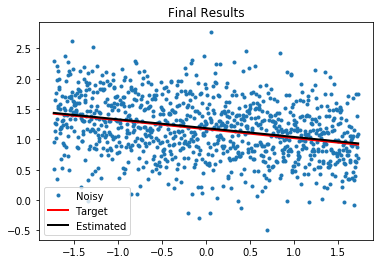

In [33]:
"""
Display Final Results
"""
plt.title('Final Results')
plt.plot(stdX, noisyDesired, '.')
plt.plot(stdX, target, 'r', linewidth=2.)
plt.plot(stdX, wHat*stdX+bHat, 'k', linewidth=2.)
plt.legend(('Noisy', 'Target', 'Estimated'))
plt.show()

In [1]:
# Future Libraries
from __future__ import print_function, division
# Python Libraries
import os
import time
# 3rd Party Libraries
# Make sure os has the GPU selected before initializing Theano
os.environ['THEANO_FLAGS'] = ",".join([
    'device=gpu',
    'floatX=float32',
    'lib.cnmem=0.9689',
    'allow_gc=False',
    'nvcc.flags=-D_FORCE_INLINES',
])
from theano import function, config, shared, tensor
import numpy

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/home/simeon/anaconda3/envs/deep/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.152075 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu
